In [17]:
import numpy as np
from pymongo import MongoClient
from PIL import Image
from io import BytesIO
import base64
import imagehash
import random
import sys

# Verbindung zu MongoDB herstellen
client = MongoClient("mongodb://localhost:27017")
db = client["fingerprintDB"]
collection = db["fingerprints"]

# Funktion zum Dekodieren von Base64-Bildern
def decode_base64_image(base64_string):
    if "," in base64_string:
        base64_data = base64_string.split(",")[1]
    else:
        raise ValueError("Invalid base64 string format")
    byte_data = base64.b64decode(base64_data)
    image_data = BytesIO(byte_data)
    image = Image.open(image_data)
    return image

# Funktion zum Abrufen der Canvases
def get_canvases(data):
    if "canvases" not in data or not isinstance(data["canvases"], list):
        raise ValueError("Invalid data format: 'canvases' key is missing or not a list")
    return [decode_base64_image(canvas) for canvas in data["canvases"]]

# Benutzername aus den Argumenten abrufen
username1 = "username_1"
username2 = "username_2"

# Positive Beispiele (Canvases des aktuellen Benutzers)
user1 = collection.find_one({"username": username1})
user2 = collection.find_one({"username": username2})

if user1 is None or user2 is None:
    print(f"One or both users not found: {username1}, {username2}")
    sys.exit(1)

# Abrufen der Canvases
user1_canvases = get_canvases(user1)
user2_canvases = get_canvases(user2)

# Zufällige Auswahl eines Canvas von jedem Benutzer für den Vergleich
image1 = random.choice(user1_canvases)
image2 = random.choice(user2_canvases)

# Generieren der Hashes
hash1 = imagehash.phash(image1)
hash2 = imagehash.phash(image2)

# Vergleichen der Hashes
hash_difference = hash1 - hash2

print(f"Hash for {username1}: {hash1}")
print(f"Hash for {username2}: {hash2}")
print(f"Hash difference: {hash_difference}")

# Bestimmen der Ähnlichkeit
if hash_difference == 0:
    print("The images are identical.")
else:
    print(f"The images are different with a hash difference of {hash_difference}.")


Hash for username_1: e31c1e1c1f1c1f3c
Hash for username_2: f10e0e0e0e1e0ffe
Hash difference: 14
The images are different with a hash difference of 14.


In [18]:
import numpy as np
import pandas as pd
from pymongo import MongoClient
from PIL import Image
from io import BytesIO
import base64
import os
import sys
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# GPU-Speicherwachstum aktivieren
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Verbindung zu MongoDB herstellen
client = MongoClient("mongodb://localhost:27017/")
db = client["fingerprintDB"]
collection = db["fingerprints"]

# Funktion zum Dekodieren von Base64-Bildern
def decode_base64_image(base64_string):
    if "," in base64_string:
        base64_data = base64_string.split(",")[1]
    else:
        raise ValueError("Invalid base64 string format")
    byte_data = base64.b64decode(base64_data)
    image_data = BytesIO(byte_data)
    image = Image.open(image_data)
    return np.array(image)

# Funktion zum Abrufen der Canvases
def get_canvases(data):
    if "canvases" not in data or not isinstance(data["canvases"], list):
        raise ValueError("Invalid data format: 'canvases' key is missing or not a list")
    return [decode_base64_image(canvas) for canvas in data["canvases"]]

# Benutzername aus den Argumenten abrufen
username = "username_2"

# Modellpfad anpassen je nach dem wo das Skript ausgeführt wird
if 'src' in os.getcwd():
    model_path = f'src/SWAT_auth/models/{username}_fingerprint_model.h5'
else:
    model_path = f'SWAT_auth/models/{username}_fingerprint_model.h5'

# Überprüfen, ob das Modell bereits existiert
if os.path.exists(model_path):
    print(f"Model for {username} already exists at {model_path}")
    sys.exit(0)

print(f"Creating model for {username}")

# Positive Beispiele (Canvases des aktuellen Benutzers)
user = collection.find_one({"username": username})
if user is None:
    print(f"No user found with username {username}")
    sys.exit(1)

user_canvases = get_canvases(user)
X_positive = np.array(user_canvases)
y_positive = np.ones(len(X_positive))

# Negative Beispiele (Canvases der anderen Benutzer)
X_negative = []
y_negative = []

for other_user in collection.find({"username": {"$ne": username}}):
    other_user_canvases = get_canvases(other_user)
    X_negative.extend(other_user_canvases)
    y_negative.extend([0] * len(other_user_canvases))

# Zufällig 2500 negative Beispiele auswählen
if len(X_negative) > 2500:
    indices = np.random.choice(len(X_negative), 2500, replace=False)
    X_negative = np.array(X_negative)[indices]
    y_negative = np.array(y_negative)[indices]
else:
    X_negative = np.array(X_negative)
    y_negative = np.array(y_negative)

# Kombinieren der Daten
X = np.concatenate((X_positive, X_negative), axis=0)
y = np.concatenate((y_positive, y_negative), axis=0)

# Aufteilen der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Daten normalisieren
X_train = X_train / 255.0
X_test = X_test / 255.0

print("Data preparation complete.")


Creating model for username_2
Data preparation complete.


In [19]:
# Modell 1 definieren
def create_model_1(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Modell 2 definieren
def create_model_2(input_shape):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Modell 3 definieren
def create_model_3(input_shape):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Modell 4 definieren (z.B. VGG-ähnliche Architektur)
def create_model_4(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Modell 5 definieren (z.B. ResNet-ähnliche Architektur)
def create_model_5(input_shape):
    model = Sequential()
    model.add(Conv2D(64, (7, 7), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Modell 6 definieren (z.B. Inception-ähnliche Architektur)
def create_model_6(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

input_shape = X_train.shape[1:]
models = [
    create_model_1(input_shape),
    create_model_2(input_shape),
    create_model_3(input_shape),
    create_model_4(input_shape),
    create_model_5(input_shape),
    create_model_6(input_shape)
]
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6']


In [20]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

best_accuracy = 0
best_model = None

# Modelle nacheinander trainieren und bewerten
results = []
for i, (model, name) in enumerate(zip(models, model_names), start=1):
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    # Speichern des Modells mit einem spezifischen Namen
    model_checkpoint = ModelCheckpoint(f'models/{username}_{i}.h5', save_best_only=True, monitor='val_accuracy', mode='max')
    
    history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test), callbacks=[early_stopping, model_checkpoint])
    
    # Modell bewerten
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"{name} - Test Loss: {loss}")
    print(f"{name} - Test Accuracy: {accuracy}")
    results.append({'Model': name, 'Accuracy': accuracy})

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

# Bestes Modell speichern
if best_model is not None:
    best_model.save(f'models/{username}_best.h5')
    print(f"Best model saved at src/SWAT_auth/models/{username}_best.h5 with accuracy {best_accuracy}")
else:
    print("No model was trained successfully.")

Epoch 1/50
440/440 [==============================] - 4s 9ms/step - loss: 0.5270 - accuracy: 0.7304 - val_loss: 0.3932 - val_accuracy: 0.8227
Epoch 2/50
440/440 [==============================] - 4s 9ms/step - loss: 0.3832 - accuracy: 0.8031 - val_loss: 0.3984 - val_accuracy: 0.8034
Epoch 3/50
307/440 [===================>..........] - ETA: 1s - loss: 0.3345 - accuracy: 0.8335

     Model  Accuracy
0  Model 1  0.876136
1  Model 2  0.864773
2  Model 3  0.937500
3  Model 4  0.994318
4  Model 5  0.912500
5  Model 6  0.980682


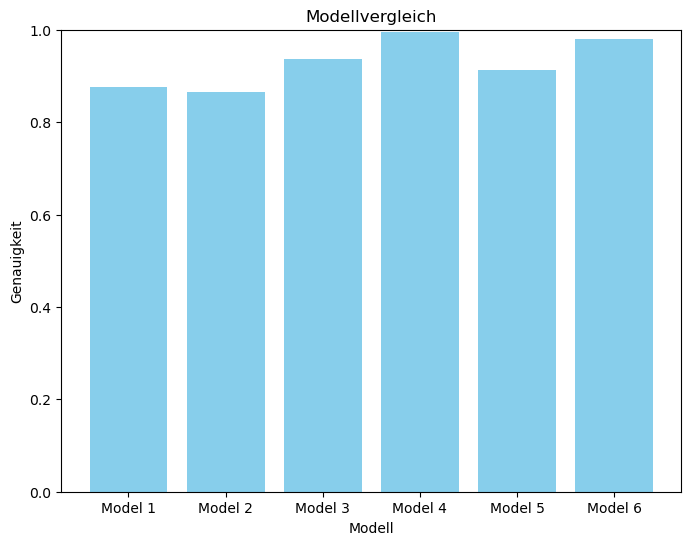

In [ ]:
  # Ergebnisse in einem DataFrame anzeigen
results_df = pd.DataFrame(results)
print(results_df)

# Ergebnisse visualisieren
plt.figure(figsize=(8, 6))
plt.bar(results_df['Model'], results_df['Accuracy'], color='skyblue')
plt.title('Modellvergleich')
plt.xlabel('Modell')
plt.ylabel('Genauigkeit')
plt.ylim(0, 1)
plt.show()


In [ ]:
import visualkeras

#for model, name in zip(models, model_names):
    # Modellarchitektur visualisieren
#    visualkeras.layered_view(model, to_file=f'{name}_architecture.png').show()


28/28 [==============================] - 0s 10ms/step - loss: 0.2576 - accuracy: 0.8761
Model 1 - Test Loss: 0.25755631923675537
Model 1 - Test Accuracy: 0.8761363625526428
28/28 [==============================] - 0s 8ms/step


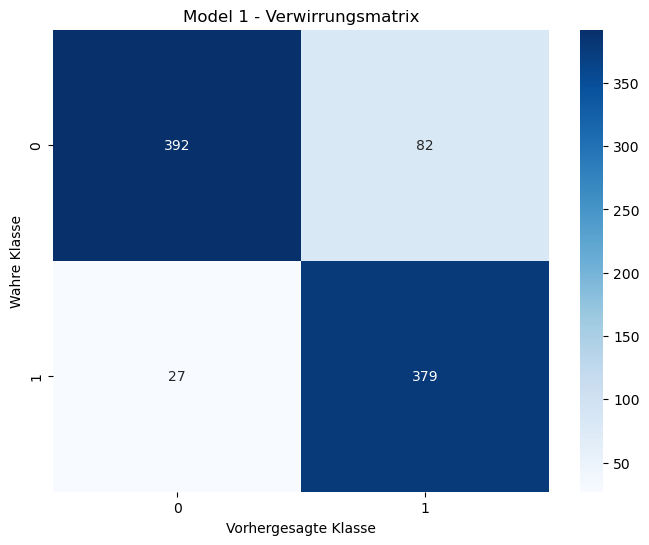

Model 1 - Klassifikationsbericht
              precision    recall  f1-score   support

         0.0       0.94      0.83      0.88       474
         1.0       0.82      0.93      0.87       406

    accuracy                           0.88       880
   macro avg       0.88      0.88      0.88       880
weighted avg       0.88      0.88      0.88       880

28/28 [==============================] - 0s 10ms/step - loss: 0.2860 - accuracy: 0.8648
Model 2 - Test Loss: 0.28600889444351196
Model 2 - Test Accuracy: 0.8647727370262146
28/28 [==============================] - 0s 4ms/step


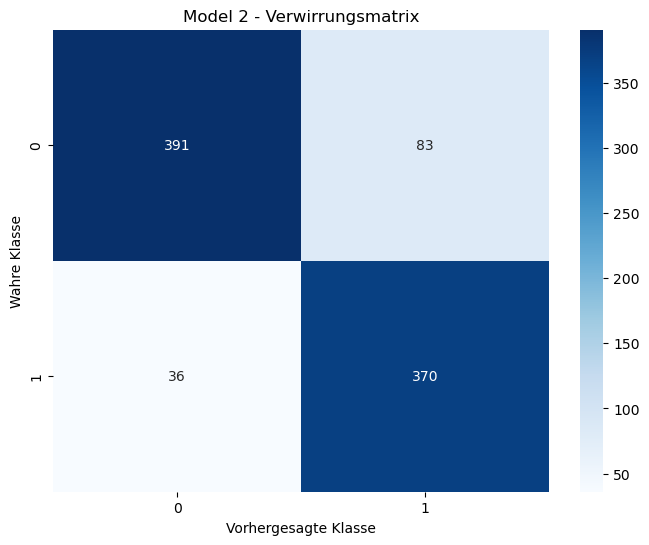

Model 2 - Klassifikationsbericht
              precision    recall  f1-score   support

         0.0       0.92      0.82      0.87       474
         1.0       0.82      0.91      0.86       406

    accuracy                           0.86       880
   macro avg       0.87      0.87      0.86       880
weighted avg       0.87      0.86      0.86       880

28/28 [==============================] - 0s 7ms/step - loss: 0.1598 - accuracy: 0.9375
Model 3 - Test Loss: 0.1598363220691681
Model 3 - Test Accuracy: 0.9375
28/28 [==============================] - 0s 5ms/step


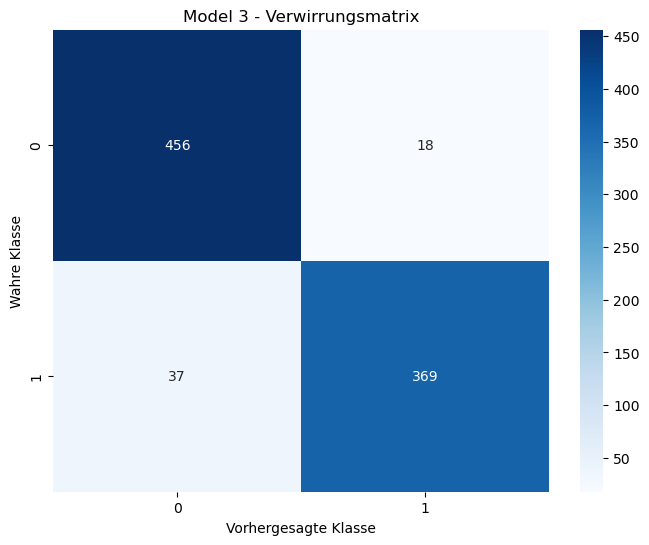

Model 3 - Klassifikationsbericht
              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94       474
         1.0       0.95      0.91      0.93       406

    accuracy                           0.94       880
   macro avg       0.94      0.94      0.94       880
weighted avg       0.94      0.94      0.94       880

28/28 [==============================] - 0s 8ms/step - loss: 0.0187 - accuracy: 0.9943
Model 4 - Test Loss: 0.018705051392316818
Model 4 - Test Accuracy: 0.9943181872367859
28/28 [==============================] - 0s 6ms/step


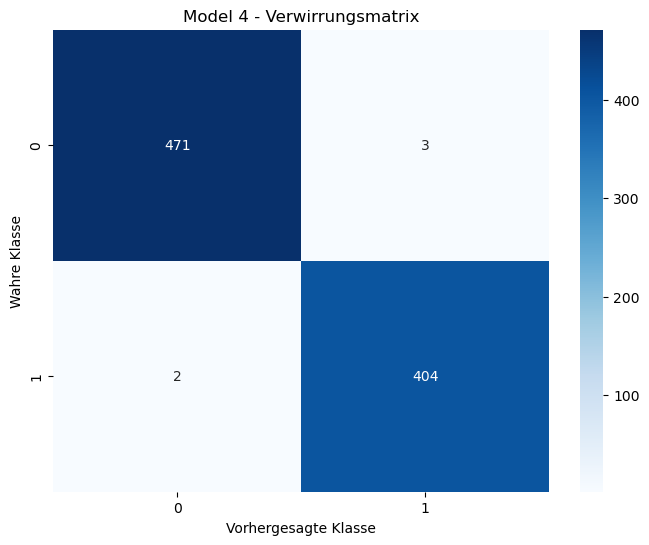

Model 4 - Klassifikationsbericht
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       474
         1.0       0.99      1.00      0.99       406

    accuracy                           0.99       880
   macro avg       0.99      0.99      0.99       880
weighted avg       0.99      0.99      0.99       880

28/28 [==============================] - 0s 9ms/step - loss: 0.1763 - accuracy: 0.9125
Model 5 - Test Loss: 0.1762736737728119
Model 5 - Test Accuracy: 0.9125000238418579
28/28 [==============================] - 0s 6ms/step


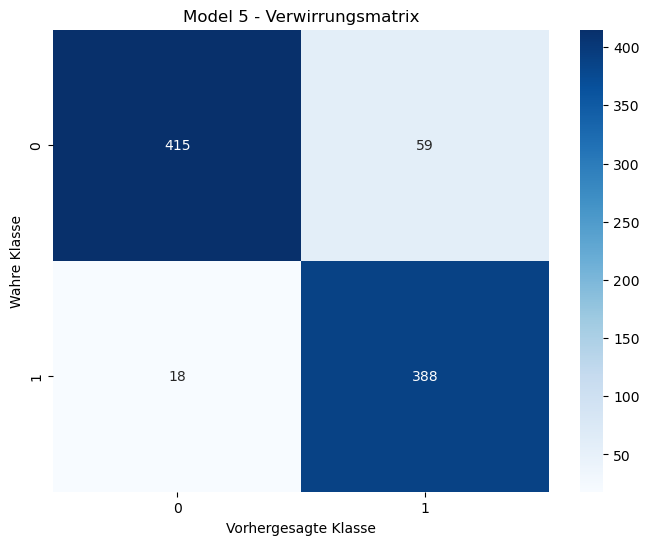

Model 5 - Klassifikationsbericht
              precision    recall  f1-score   support

         0.0       0.96      0.88      0.92       474
         1.0       0.87      0.96      0.91       406

    accuracy                           0.91       880
   macro avg       0.91      0.92      0.91       880
weighted avg       0.92      0.91      0.91       880

28/28 [==============================] - 0s 7ms/step - loss: 0.0512 - accuracy: 0.9807
Model 6 - Test Loss: 0.0512300506234169
Model 6 - Test Accuracy: 0.980681836605072
28/28 [==============================] - 0s 4ms/step


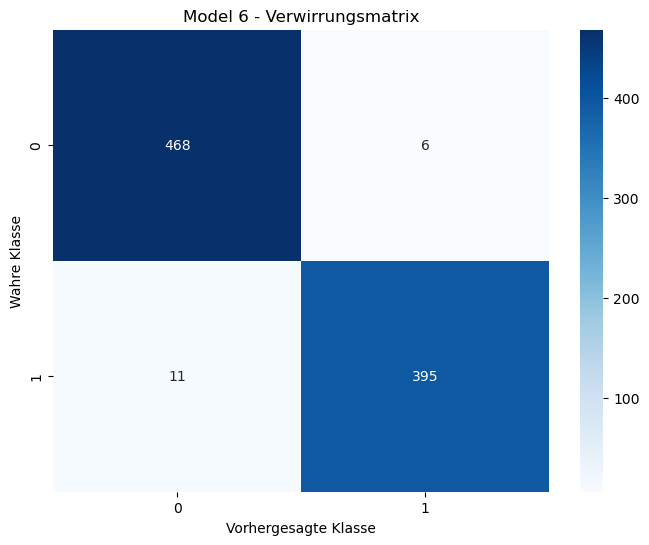

Model 6 - Klassifikationsbericht
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       474
         1.0       0.99      0.97      0.98       406

    accuracy                           0.98       880
   macro avg       0.98      0.98      0.98       880
weighted avg       0.98      0.98      0.98       880



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

for model, name in zip(models, model_names):
    # Modell bewerten
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"{name} - Test Loss: {loss}")
    print(f"{name} - Test Accuracy: {accuracy}")

    # Vorhersagen auf dem Testdatensatz
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype("int32")

    # Verwirrungsmatrix erstellen
    conf_matrix = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Verwirrungsmatrix')
    plt.xlabel('Vorhergesagte Klasse')
    plt.ylabel('Wahre Klasse')
    plt.show()

    # Klassifikationsbericht anzeigen
    print(f"{name} - Klassifikationsbericht")
    print(classification_report(y_test, y_pred_classes))



Testing models with prefix: username_4
Loaded models: ['username_4_1.h5', 'username_4_2.h5', 'username_4_3.h5', 'username_4_4.h5', 'username_4_5.h5', 'username_4_6.h5', 'username_4_best.h5']
Loading random canvas for username: username_4
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_4
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_2
1/1 [==============================] - 0s 22ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Results for model: username_4_1.h5
Against fingerprints of username_4:
Test 1: Prediction = 0.9860402345657349
Test 2: Prediction = 0.9998905658721924
Test 3: Prediction = 0.9999948740005493
Test 4: Prediction = 0.999894380569458
Test 5: Prediction = 0.7391125559806824
Against fingerprints of username_2:
Test 1: Prediction = 1.2280539252174094e-08
Test 2: Prediction = 1.3401592661131667e-13
Test 3: Prediction = 7.1152981035993434e-06
Test 4: Prediction = 6.218021930681772e-11
Test 5: Prediction = 3.329794393772817e-13

Results for model: username_4_2.h5
Against fingerprints of username_4:
Test 1: Prediction = 0.7322707176208496
Test 2: Prediction = 0.9999654293060303
Test 3: Prediction = 0.9999792575836182
Test 4: Prediction = 0.9999891519546509
Test 5: Prediction = 0.659239649772644
Against fingerprints of username_2:
Test 1: Prediction = 1.146874373247897e-09
Test 2: Prediction = 1.317245288472396e-16
Test 3: Prediction = 1.0059703292597533e-08
Test 4: Prediction = 2.468379278752763

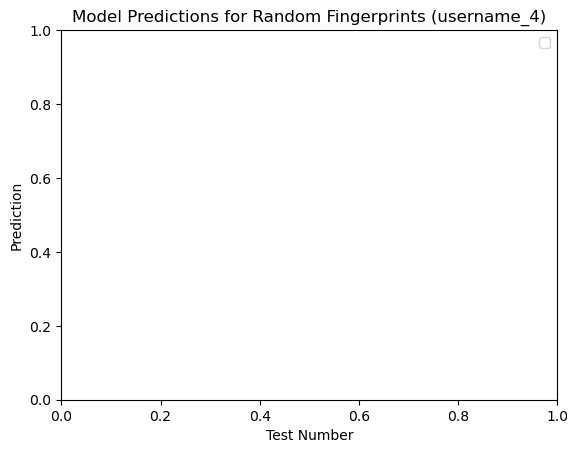


Testing models with prefix: username_2
Loaded models: ['username_2_1.h5', 'username_2_2.h5', 'username_2_3.h5', 'username_2_4.h5', 'username_2_5.h5', 'username_2_6.h5', 'username_2_best.h5']
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_4
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_2
Loading random canvas for username: username_2
1/1 [==============================] - 0s 22ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Results for model: username_2_1.h5
Against fingerprints of username_4:
Test 1: Prediction = 0.004545056726783514
Test 2: Prediction = 0.03241293504834175
Test 3: Prediction = 0.0001873988949228078
Against fingerprints of username_2:
Test 1: Prediction = 0.7218361496925354
Test 2: Prediction = 0.7721511125564575
Test 3: Prediction = 0.7361859679222107
Test 4: Prediction = 0.7895196676254272
Test 5: Prediction = 0.7566648721694946
Test 6: Prediction = 0.7023522853851318
Test 7: Prediction = 0.7607899904251099

Results for model: username_2_2.h5
Against fingerprints of username_4:
Test 1: Prediction = 0.01202042493969202
Test 2: Prediction = 0.1780584454536438
Test 3: Prediction = 0.00013064964150544256
Against fingerprints of username_2:
Test 1: Prediction = 0.7607547640800476
Test 2: Prediction = 0.7474527359008789
Test 3: Prediction = 0.8178332448005676
Test 4: Prediction = 0.9399653673171997
Test 5: Prediction = 0.7936338186264038
Test 6: Prediction = 0.820042073726654
Test 7: Predic

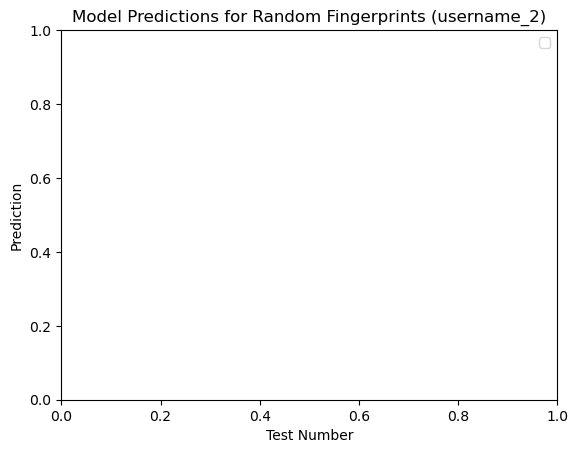

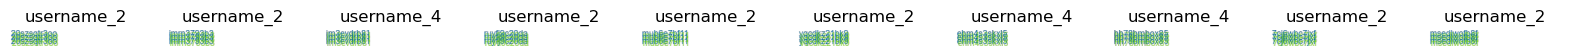

In [ ]:
import numpy as np
from pymongo import MongoClient
from PIL import Image
from io import BytesIO
import base64
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# Verbindung zu MongoDB herstellen
client = MongoClient("mongodb://localhost:27017/")
db = client["fingerprintDB"]
collection = db["fingerprints"]

# Funktion zum Dekodieren von Base64-Bildern
def decode_base64_image(base64_string):
    if "," in base64_string:
        base64_data = base64_string.split(",")[1]
    else:
        base64_data = base64_string
    byte_data = base64.b64decode(base64_data)
    image_data = BytesIO(byte_data)
    image = Image.open(image_data)
    return image

# Funktion zum Vorbereiten des Bildes für das Modell
def prepare_image(image, target_size):
    image_resized = image.resize(target_size)  # Bild auf die Zielgröße ändern
    image_array_resized = np.array(image_resized)
    if image_array_resized.shape[-1] == 3:  # Wenn das Bild keine Alpha-Kanäle hat, fügen Sie einen hinzu
        image_array_resized = np.concatenate([image_array_resized, np.ones((*image_array_resized.shape[:2], 1)) * 255], axis=-1)
    image_array_normalized = image_array_resized / 255.0
    image_array_normalized = np.expand_dims(image_array_normalized, axis=0)
    return image_array_normalized

# Funktion zum Laden der Modelle basierend auf Präfixen
def load_models(model_dir, prefixes):
    model_paths = [os.path.join(model_dir, f) for f in os.listdir(model_dir) if any(f.startswith(prefix) for prefix in prefixes)]
    model_names = [os.path.basename(path) for path in model_paths]
    models = []
    for path in model_paths:
        if os.path.exists(path):
            models.append(tf.keras.models.load_model(path, compile=False))
        else:
            print(f"Model file not found: {path}")
    for model in models:
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return models, model_names

# Zufälligen Fingerabdruck aus der Datenbank laden
def get_random_fingerprint(username):
    fingerprints = list(collection.aggregate([{"$match": {"username": username}}, {"$sample": {"size": 1}}]))
    if not fingerprints:
        raise ValueError(f"No fingerprints found in the database for username: {username}")
    random_fingerprint = fingerprints[0]
    if 'canvases' not in random_fingerprint or not random_fingerprint['canvases']:
        raise KeyError("The field 'canvases' was not found in the document or is empty")
    base64_image = random.choice(random_fingerprint['canvases'])  # Zufälliges Bild aus dem 'canvases'-Array auswählen
    return decode_base64_image(base64_image)

# Mehrere Fingerabdrücke abrufen und vorbereiten
def get_multiple_fingerprints(usernames, num_tests):
    images = []
    for _ in range(num_tests):
        username = random.choice(usernames)
        print(f"Loading random canvas for username: {username}")
        image = get_random_fingerprint(username)
        images.append((username, image))
    return images

# Präfixe für die Modelle
prefixes = ["username_4", "username_2"]  # Beispiel: kann auch andere Präfixe enthalten

# Anzahl der Tests
num_tests = 10

# Modelle laden und testen
for prefix in prefixes:
    print(f"\nTesting models with prefix: {prefix}")
    models, model_names = load_models('models', [prefix])
    
    # Geladene Modelle anzeigen
    print(f"Loaded models: {model_names}")
    
    # Mehrere Fingerabdrücke abrufen und vorbereiten
    images = get_multiple_fingerprints(prefixes, num_tests)
    prepared_images = [(username, prepare_image(image, target_size=(280, 35))) for username, image in images]
    
    # Ergebnisse speichern
    all_results = {name: {username: [] for username in prefixes} for name in model_names}
    for username, image_array_normalized in prepared_images:
        for model, name in zip(models, model_names):
            prediction = model.predict(image_array_normalized)
            all_results[name][username].append(prediction[0][0])
    
    # Ergebnisse in der Konsole ausgeben
    for name in model_names:
        print(f"\nResults for model: {name}")
        for username in prefixes:
            print(f"Against fingerprints of {username}:")
            for i, result in enumerate(all_results[name][username]):
                print(f"Test {i+1}: Prediction = {result}")
    
    # Ergebnisse grafisch darstellen
    fig, ax = plt.subplots()
    for name in model_names:
        for username in prefixes:
            if len(all_results[name][username]) == num_tests:
                ax.plot(range(num_tests), all_results[name][username], label=f"{name} vs {username}")
    ax.set_xlabel('Test Number')
    ax.set_ylabel('Prediction')
    ax.set_title(f'Model Predictions for Random Fingerprints ({prefix})')
    ax.legend()
    plt.show()

# Fingerabdrücke anzeigen
fig, axes = plt.subplots(1, num_tests, figsize=(20, 5))
for i, (username, image) in enumerate(images):
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(username)
    axes[i].axis('off')
plt.show()


Testing models with prefix: username_4
Loaded models: ['username_4_1.h5', 'username_4_2.h5', 'username_4_3.h5', 'username_4_4.h5', 'username_4_5.h5', 'username_4_6.h5', 'username_4_best.h5']
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_4
1/1 [==============================] - 0s 24ms/step

Results for model: username_4_1.h5
Test 1: Prediction = 0.9976043105125427
Test 2: Prediction = 0.9999979734420776
Test 3: Prediction = 0.999997615814209
Test 4: Prediction = 0.9998905658721924
Test 5: Prediction = 0.9998999834060669
Test 6: Prediction = 0.9999990463256836
Test 7: Pre

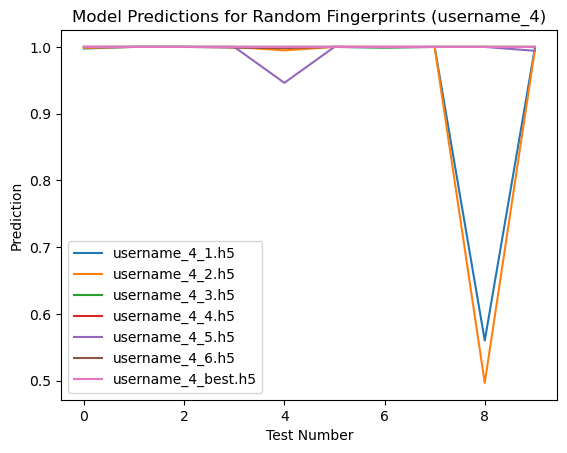


Testing models with prefix: username_2
Loaded models: ['username_2_1.h5', 'username_2_2.h5', 'username_2_3.h5', 'username_2_4.h5', 'username_2_5.h5', 'username_2_6.h5', 'username_2_best.h5']
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
1/1 [==============================] - 0s 23ms/step

Results for model: username_2_1.h5
Test 1: Prediction = 0.7433041334152222
Test 2: Prediction = 0.6993160843849182
Test 3: Prediction = 0.7023522853851318
Test 4: Prediction = 0.6980674862861633
Test 5: Prediction = 0.7462739944458008
Test 6: Prediction = 0.7600006461143494
Test 7: Pr

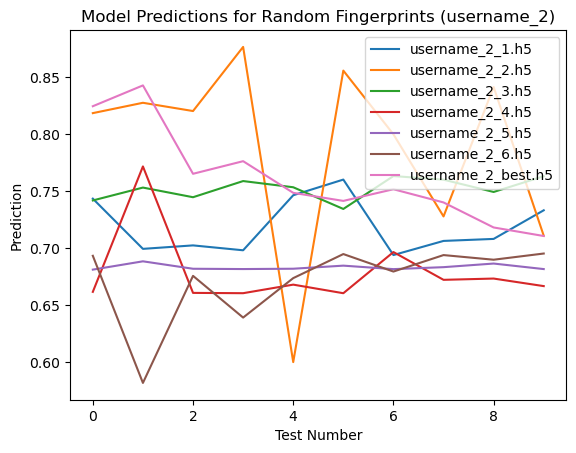

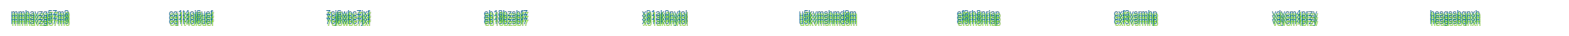

In [ ]:
import numpy as np
from pymongo import MongoClient
from PIL import Image
from io import BytesIO
import base64
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# Verbindung zu MongoDB herstellen
client = MongoClient("mongodb://localhost:27017/")
db = client["fingerprintDB"]
collection = db["fingerprints"]

# Funktion zum Dekodieren von Base64-Bildern
def decode_base64_image(base64_string):
    if "," in base64_string:
        base64_data = base64_string.split(",")[1]
    else:
        base64_data = base64_string
    byte_data = base64.b64decode(base64_data)
    image_data = BytesIO(byte_data)
    image = Image.open(image_data)
    return image

# Funktion zum Vorbereiten des Bildes für das Modell
def prepare_image(image, target_size):
    image_resized = image.resize(target_size)  # Bild auf die Zielgröße ändern
    image_array_resized = np.array(image_resized)
    if image_array_resized.shape[-1] == 3:  # Wenn das Bild keine Alpha-Kanäle hat, fügen Sie einen hinzu
        image_array_resized = np.concatenate([image_array_resized, np.ones((*image_array_resized.shape[:2], 1)) * 255], axis=-1)
    image_array_normalized = image_array_resized / 255.0
    image_array_normalized = np.expand_dims(image_array_normalized, axis=0)
    return image_array_normalized

# Funktion zum Laden der Modelle basierend auf Präfixen
def load_models(model_dir, prefixes):
    model_paths = [os.path.join(model_dir, f) for f in os.listdir(model_dir) if any(f.startswith(prefix) for prefix in prefixes)]
    model_names = [os.path.basename(path) for path in model_paths]
    models = []
    for path in model_paths:
        if os.path.exists(path):
            models.append(tf.keras.models.load_model(path, compile=False))
        else:
            print(f"Model file not found: {path}")
    for model in models:
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return models, model_names

# Zufälligen Fingerabdruck aus der Datenbank laden
def get_random_fingerprint(username):
    fingerprints = list(collection.aggregate([{"$match": {"username": username}}, {"$sample": {"size": 1}}]))
    if not fingerprints:
        raise ValueError(f"No fingerprints found in the database for username: {username}")
    random_fingerprint = fingerprints[0]
    if 'canvases' not in random_fingerprint or not random_fingerprint['canvases']:
        raise KeyError("The field 'canvases' was not found in the document or is empty")
    base64_image = random.choice(random_fingerprint['canvases'])  # Zufälliges Bild aus dem 'canvases'-Array auswählen
    return decode_base64_image(base64_image)

# Mehrere Fingerabdrücke abrufen und vorbereiten
def get_multiple_fingerprints(usernames, num_tests):
    images = []
    for _ in range(num_tests):
        username = random.choice(usernames)
        print(f"Loading random canvas for username: {username}")
        image = get_random_fingerprint(username)
        images.append(image)
    return images

# Präfixe für die Modelle
prefixes = ["username_4", "username_2"]  # Beispiel: kann auch andere Präfixe enthalten

# Anzahl der Tests
num_tests = 10

# Modelle laden und testen
for prefix in prefixes:
    print(f"\nTesting models with prefix: {prefix}")
    models, model_names = load_models('models', [prefix])
    
    # Geladene Modelle anzeigen
    print(f"Loaded models: {model_names}")
    
    # Mehrere Fingerabdrücke abrufen und vorbereiten
    images = get_multiple_fingerprints([prefix], num_tests)
    prepared_images = [prepare_image(image, target_size=(280, 35)) for image in images]
    
    # Ergebnisse speichern
    all_results = {name: [] for name in model_names}
    for image_array_normalized in prepared_images:
        for model, name in zip(models, model_names):
            prediction = model.predict(image_array_normalized)
            all_results[name].append(prediction[0][0])
    
    # Ergebnisse in der Konsole ausgeben
    for name in model_names:
        print(f"\nResults for model: {name}")
        for i, result in enumerate(all_results[name]):
            print(f"Test {i+1}: Prediction = {result}")
    
    # Ergebnisse grafisch darstellen
    fig, ax = plt.subplots()
    for name in model_names:
        ax.plot(range(num_tests), all_results[name], label=name)
    ax.set_xlabel('Test Number')
    ax.set_ylabel('Prediction')
    ax.set_title(f'Model Predictions for Random Fingerprints ({prefix})')
    ax.legend()
    plt.show()

# Fingerabdrücke anzeigen
fig, axes = plt.subplots(1, num_tests, figsize=(20, 5))
for i, image in enumerate(images):
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')
plt.show()



Testing models with prefix: username_4
Loaded models: ['username_4_1.h5', 'username_4_2.h5', 'username_4_3.h5', 'username_4_4.h5', 'username_4_5.h5', 'username_4_6.h5', 'username_4_best.h5']
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_4
Loading random canvas for username: username_2
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
1/1 [==============================] - 0s 22ms/step

Results for model: username_4_1.h5
Test 1: Username = username_2, Prediction = 9.717680132803608e-11
Test 2: Username = username_2, Prediction = 2.0048010560685947e-12
Test 3: Username = username_2, Prediction = 7.568302538493721e-13
Test 4: Username = username_4, Prediction = 0.99977

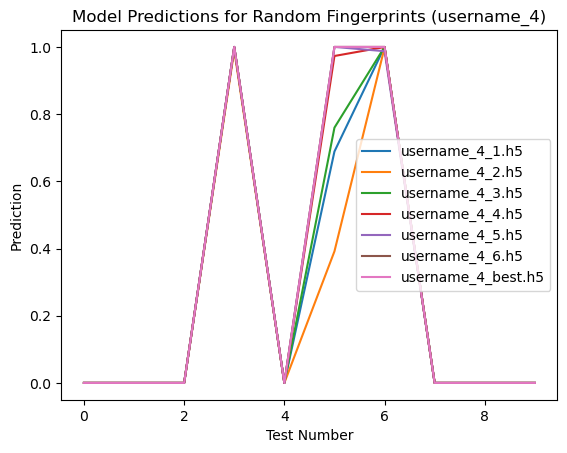


Testing models with prefix: username_2
Loaded models: ['username_2_1.h5', 'username_2_2.h5', 'username_2_3.h5', 'username_2_4.h5', 'username_2_5.h5', 'username_2_6.h5', 'username_2_best.h5']
Loading random canvas for username: username_4
Loading random canvas for username: username_2
Loading random canvas for username: username_4
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_4
Loading random canvas for username: username_2
1/1 [==============================] - 0s 22ms/step

Results for model: username_2_1.h5
Test 1: Username = username_4, Prediction = 0.013536007143557072
Test 2: Username = username_2, Prediction = 0.6928662061691284
Test 3: Username = username_4, Prediction = 0.002417271723970771
Test 4: Username = username_2, Prediction = 0.76350444555

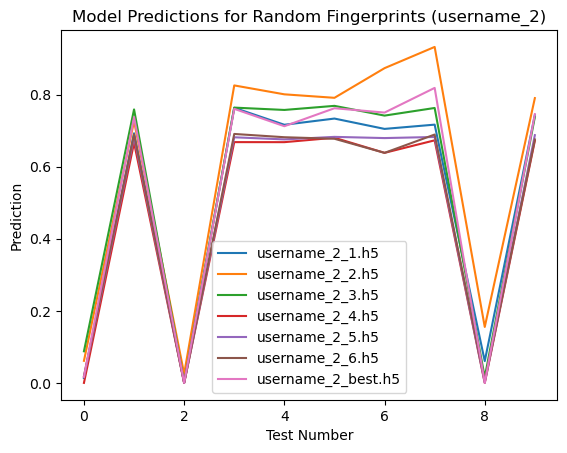

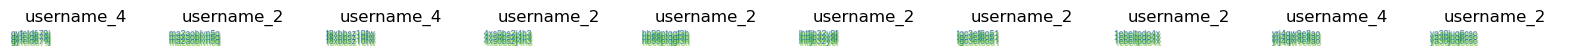

In [ ]:
import numpy as np
from pymongo import MongoClient
from PIL import Image
from io import BytesIO
import base64
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# Verbindung zu MongoDB herstellen
client = MongoClient("mongodb://localhost:27017/")
db = client["fingerprintDB"]
collection = db["fingerprints"]

# Funktion zum Dekodieren von Base64-Bildern
def decode_base64_image(base64_string):
    if "," in base64_string:
        base64_data = base64_string.split(",")[1]
    else:
        base64_data = base64_string
    byte_data = base64.b64decode(base64_data)
    image_data = BytesIO(byte_data)
    image = Image.open(image_data)
    return image

# Funktion zum Vorbereiten des Bildes für das Modell
def prepare_image(image, target_size):
    image_resized = image.resize(target_size)  # Bild auf die Zielgröße ändern
    image_array_resized = np.array(image_resized)
    if image_array_resized.shape[-1] == 3:  # Wenn das Bild keine Alpha-Kanäle hat, fügen Sie einen hinzu
        image_array_resized = np.concatenate([image_array_resized, np.ones((*image_array_resized.shape[:2], 1)) * 255], axis=-1)
    image_array_normalized = image_array_resized / 255.0
    image_array_normalized = np.expand_dims(image_array_normalized, axis=0)
    return image_array_normalized

# Funktion zum Laden der Modelle basierend auf Präfixen
def load_models(model_dir, prefixes):
    model_paths = [os.path.join(model_dir, f) for f in os.listdir(model_dir) if any(f.startswith(prefix) for prefix in prefixes)]
    model_names = [os.path.basename(path) for path in model_paths]
    models = []
    for path in model_paths:
        if os.path.exists(path):
            models.append(tf.keras.models.load_model(path, compile=False))
        else:
            print(f"Model file not found: {path}")
    for model in models:
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return models, model_names

# Zufälligen Fingerabdruck aus der Datenbank laden
def get_random_fingerprint(username):
    fingerprints = list(collection.aggregate([{"$match": {"username": username}}, {"$sample": {"size": 1}}]))
    if not fingerprints:
        raise ValueError(f"No fingerprints found in the database for username: {username}")
    random_fingerprint = fingerprints[0]
    if 'canvases' not in random_fingerprint or not random_fingerprint['canvases']:
        raise KeyError("The field 'canvases' was not found in the document or is empty")
    base64_image = random.choice(random_fingerprint['canvases'])  # Zufälliges Bild aus dem 'canvases'-Array auswählen
    return decode_base64_image(base64_image)

# Mehrere Fingerabdrücke abrufen und vorbereiten
def get_multiple_fingerprints(usernames, num_tests):
    images = []
    for _ in range(num_tests):
        username = random.choice(usernames)
        print(f"Loading random canvas for username: {username}")
        image = get_random_fingerprint(username)
        images.append((username, image))
    return images

# Präfixe für die Modelle
prefixes = ["username_4", "username_2"]  # Beispiel: kann auch andere Präfixe enthalten

# Anzahl der Tests
num_tests = 10

# Modelle laden und testen
for prefix in prefixes:
    print(f"\nTesting models with prefix: {prefix}")
    models, model_names = load_models('models', [prefix])
    
    # Geladene Modelle anzeigen
    print(f"Loaded models: {model_names}")
    
    # Mehrere Fingerabdrücke abrufen und vorbereiten
    images = get_multiple_fingerprints(prefixes, num_tests)
    prepared_images = [(username, prepare_image(image, target_size=(280, 35))) for username, image in images]
    
    # Ergebnisse speichern
    all_results = {name: [] for name in model_names}
    for username, image_array_normalized in prepared_images:
        for model, name in zip(models, model_names):
            prediction = model.predict(image_array_normalized)
            all_results[name].append((username, prediction[0][0]))
    
    # Ergebnisse in der Konsole ausgeben
    for name in model_names:
        print(f"\nResults for model: {name}")
        for i, (username, result) in enumerate(all_results[name]):
            print(f"Test {i+1}: Username = {username}, Prediction = {result}")
    
    # Ergebnisse grafisch darstellen
    fig, ax = plt.subplots()
    for name in model_names:
        results = [result for username, result in all_results[name]]
        ax.plot(range(num_tests), results, label=name)
    ax.set_xlabel('Test Number')
    ax.set_ylabel('Prediction')
    ax.set_title(f'Model Predictions for Random Fingerprints ({prefix})')
    ax.legend()
    plt.show()

# Fingerabdrücke anzeigen
fig, axes = plt.subplots(1, num_tests, figsize=(20, 5))
for i, (username, image) in enumerate(images):
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(username)
    axes[i].axis('off')
plt.show()



Testing models with prefix: username_4
Loaded models: ['username_4_1.h5', 'username_4_2.h5', 'username_4_3.h5', 'username_4_4.h5', 'username_4_5.h5', 'username_4_6.h5', 'username_4_best.h5']

Testing models with fingerprints from username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_4
1/1 [==============================] - 0s 24ms/step

Results for model: username_4_1.h5
Test 1: Username = username_4, Prediction = 0.9999158382415771
Test 2: Username = username_4, Prediction = 0.9999758005142212
Test 3: Username = username_4, Prediction = 0.9982446432113647
Test 4: Use

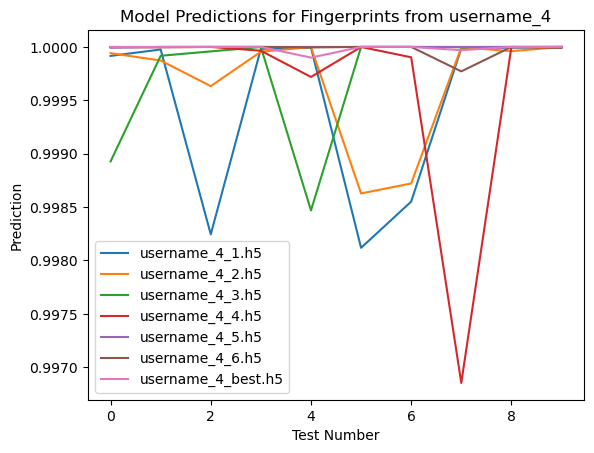

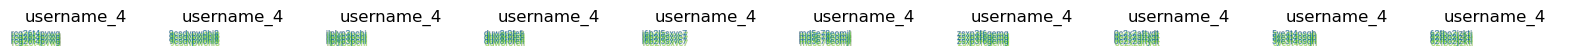


Testing models with fingerprints from username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
1/1 [==============================] - 0s 25ms/step

Results for model: username_4_1.h5
Test 1: Username = username_2, Prediction = 1.3700636181113168e-08
Test 2: Username = username_2, Prediction = 2.058088560685789e-10
Test 3: Username = username_2, Prediction = 1.5946085563101065e-09
Test 4: Username = username_2, Prediction = 5.1582938529577075e-15
Test 5: Username = username_2, Prediction = 4.435707356975627e-11
Test 6: Username = username_2, Prediction = 2.5412544291114

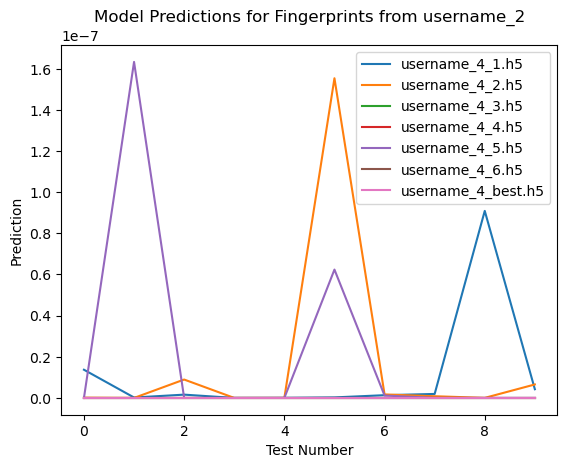

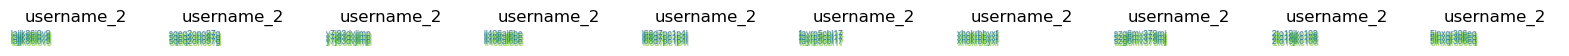


Testing models with prefix: username_2
Loaded models: ['username_2_1.h5', 'username_2_2.h5', 'username_2_3.h5', 'username_2_4.h5', 'username_2_5.h5', 'username_2_6.h5', 'username_2_best.h5']

Testing models with fingerprints from username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
Loading random canvas for username: username_2
1/1 [==============================] - 0s 27ms/step

Results for model: username_2_1.h5
Test 1: Username = username_2, Prediction = 0.6673532724380493
Test 2: Username = username_2, Prediction = 0.665438711643219
Test 3: Username = username_2, Prediction = 0.6678249835968018
Test 4: User

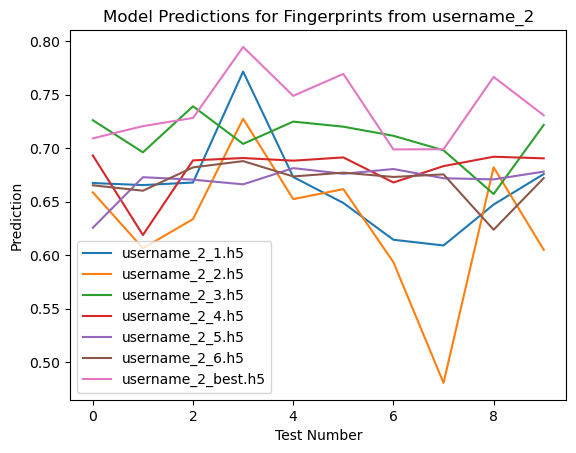

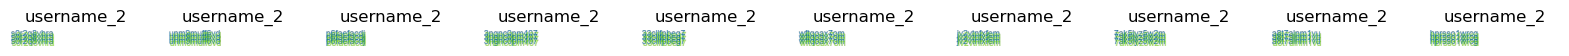


Testing models with fingerprints from username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_4
Loading random canvas for username: username_4
1/1 [==============================] - 0s 29ms/step

Results for model: username_2_1.h5
Test 1: Username = username_4, Prediction = 0.0023871595039963722
Test 2: Username = username_4, Prediction = 0.060429997742176056
Test 3: Username = username_4, Prediction = 0.004579642787575722
Test 4: Username = username_4, Prediction = 0.01725589670240879
Test 5: Username = username_4, Prediction = 0.017793651670217514
Test 6: Username = username_4, Prediction = 0.005847454071044922
Te

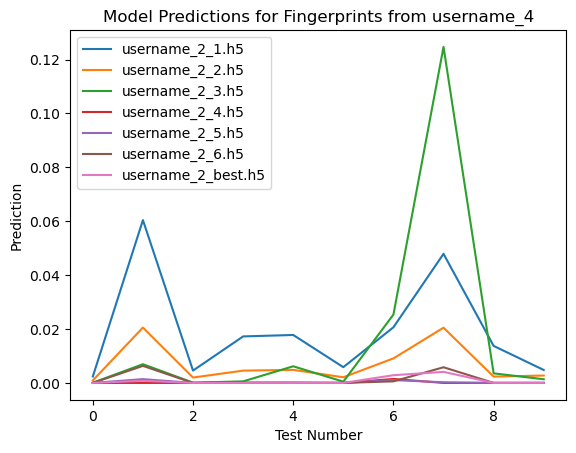

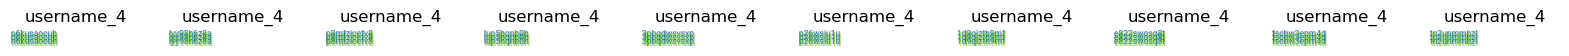

In [1]:
import numpy as np
from pymongo import MongoClient
from PIL import Image
from io import BytesIO
import base64
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# Verbindung zu MongoDB herstellen
client = MongoClient("mongodb://localhost:27017/")
db = client["fingerprintDB"]
collection = db["fingerprints"]

# Funktion zum Dekodieren von Base64-Bildern
def decode_base64_image(base64_string):
    if "," in base64_string:
        base64_data = base64_string.split(",")[1]
    else:
        base64_data = base64_string
    byte_data = base64.b64decode(base64_data)
    image_data = BytesIO(byte_data)
    image = Image.open(image_data)
    return image

# Funktion zum Vorbereiten des Bildes für das Modell
def prepare_image(image, target_size):
    image_resized = image.resize(target_size)  # Bild auf die Zielgröße ändern
    image_array_resized = np.array(image_resized)
    if image_array_resized.shape[-1] == 3:  # Wenn das Bild keine Alpha-Kanäle hat, fügen Sie einen hinzu
        image_array_resized = np.concatenate([image_array_resized, np.ones((*image_array_resized.shape[:2], 1)) * 255], axis=-1)
    image_array_normalized = image_array_resized / 255.0
    image_array_normalized = np.expand_dims(image_array_normalized, axis=0)
    return image_array_normalized

# Funktion zum Laden der Modelle basierend auf Präfixen
def load_models(model_dir, prefixes):
    model_paths = [os.path.join(model_dir, f) for f in os.listdir(model_dir) if any(f.startswith(prefix) for prefix in prefixes)]
    model_names = [os.path.basename(path) for path in model_paths]
    models = []
    for path in model_paths:
        if os.path.exists(path):
            models.append(tf.keras.models.load_model(path, compile=False))
        else:
            print(f"Model file not found: {path}")
    for model in models:
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return models, model_names

# Zufälligen Fingerabdruck aus der Datenbank laden
def get_random_fingerprint(username):
    fingerprints = list(collection.aggregate([{"$match": {"username": username}}, {"$sample": {"size": 1}}]))
    if not fingerprints:
        raise ValueError(f"No fingerprints found in the database for username: {username}")
    random_fingerprint = fingerprints[0]
    if 'canvases' not in random_fingerprint or not random_fingerprint['canvases']:
        raise KeyError("The field 'canvases' was not found in the document or is empty")
    base64_image = random.choice(random_fingerprint['canvases'])  # Zufälliges Bild aus dem 'canvases'-Array auswählen
    return decode_base64_image(base64_image)

# Mehrere Fingerabdrücke abrufen und vorbereiten
def get_multiple_fingerprints(usernames, num_tests):
    images = []
    for _ in range(num_tests):
        username = random.choice(usernames)
        print(f"Loading random canvas for username: {username}")
        image = get_random_fingerprint(username)
        images.append((username, image))
    return images

# Präfixe für die Modelle
prefixes = ["username_4", "username_2"]  # Beispiel: kann auch andere Präfixe enthalten

# Anzahl der Tests
num_tests = 10

# Modelle laden und testen
for prefix in prefixes:
    print(f"\nTesting models with prefix: {prefix}")
    models, model_names = load_models('models', [prefix])
    
    # Geladene Modelle anzeigen
    print(f"Loaded models: {model_names}")
    
    # Testen der Modelle mit Fingerabdrücken des gleichen Präfixes
    print(f"\nTesting models with fingerprints from {prefix}")
    images = get_multiple_fingerprints([prefix], num_tests)
    prepared_images = [(username, prepare_image(image, target_size=(280, 35))) for username, image in images]
    
    # Ergebnisse speichern
    all_results = {name: [] for name in model_names}
    for username, image_array_normalized in prepared_images:
        for model, name in zip(models, model_names):
            prediction = model.predict(image_array_normalized)
            all_results[name].append((username, prediction[0][0]))
    
    # Ergebnisse in der Konsole ausgeben
    for name in model_names:
        print(f"\nResults for model: {name}")
        for i, (username, result) in enumerate(all_results[name]):
            print(f"Test {i+1}: Username = {username}, Prediction = {result}")
    
    # Ergebnisse grafisch darstellen
    fig, ax = plt.subplots()
    for name in model_names:
        results = [result for username, result in all_results[name]]
        ax.plot(range(num_tests), results, label=name)
    ax.set_xlabel('Test Number')
    ax.set_ylabel('Prediction')
    ax.set_title(f'Model Predictions for Fingerprints from {prefix}')
    ax.legend()
    plt.show()

    # Fingerabdrücke anzeigen
    fig, axes = plt.subplots(1, num_tests, figsize=(20, 5))
    for i, (username, image) in enumerate(images):
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(username)
        axes[i].axis('off')
    plt.show()

    # Testen der Modelle mit Fingerabdrücken von anderen Präfixen
    other_prefixes = [p for p in prefixes if p != prefix]
    for other_prefix in other_prefixes:
        print(f"\nTesting models with fingerprints from {other_prefix}")
        images = get_multiple_fingerprints([other_prefix], num_tests)
        prepared_images = [(username, prepare_image(image, target_size=(280, 35))) for username, image in images]
        
        # Ergebnisse speichern
        all_results = {name: [] for name in model_names}
        for username, image_array_normalized in prepared_images:
            for model, name in zip(models, model_names):
                prediction = model.predict(image_array_normalized)
                all_results[name].append((username, prediction[0][0]))
        
        # Ergebnisse in der Konsole ausgeben
        for name in model_names:
            print(f"\nResults for model: {name}")
            for i, (username, result) in enumerate(all_results[name]):
                print(f"Test {i+1}: Username = {username}, Prediction = {result}")
        
        # Ergebnisse grafisch darstellen
        fig, ax = plt.subplots()
        for name in model_names:
            results = [result for username, result in all_results[name]]
            ax.plot(range(num_tests), results, label=name)
        ax.set_xlabel('Test Number')
        ax.set_ylabel('Prediction')
        ax.set_title(f'Model Predictions for Fingerprints from {other_prefix}')
        ax.legend()
        plt.show()

        # Fingerabdrücke anzeigen
        fig, axes = plt.subplots(1, num_tests, figsize=(20, 5))
        for i, (username, image) in enumerate(images):
            axes[i].imshow(image, cmap='gray')
            axes[i].set_title(username)
            axes[i].axis('off')
        plt.show()
